# import + functions

In [60]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
from moviepy.editor import *

def get_csv_speed_align_time(Tracking_sleep_data,align_path,save,Probe):
    dlc_data =get_dlc_data(Tracking_sleep_data,'body_centre',True,0.9995)

    all_distances = []
    for data_ in dlc_data:
        all_distances+=[get_distances(data_)]
    distances = np.mean(all_distances,axis = 0)
    align = pd.read_csv(align_path)

    if Probe == 'A':
        Camera_EPhys_aligned= align['Camera_time_Ephys_Aligned'].values#
    elif Probe == 'B':
        Camera_EPhys_aligned= align['Camera_time_Ephys_Aligned_probeB'].values

    # cut down to epoch i care about
    if 'Post' in align_path:
        distances = distances[align['index'].values[0]:align['index'].values[-1]+1]
    else:
        distances = distances[0:align['index'].values[-1]+1]

    fig, axs = plt.subplots(1, 2,figsize=(10, 4))

    axs[0].plot(distances, color = 'blue')
    axs[0].set_title('Distance')
    if 'Post' in align_path:
        axs[1].plot(dlc_data[0]['interped_x'][align['index'].values[0]::].values,color = 'red',markersize=1)
        axs[1].plot(dlc_data[0]['interped_y'][align['index'].values[0]::].values,color = 'green',markersize=1)
    else:
        axs[1].plot(dlc_data[0]['interped_x'][0:align['index'].values[-1]].values,color = 'red',markersize=1)
        axs[1].plot(dlc_data[0]['interped_y'][0:align['index'].values[-1]].values,color = 'green',markersize=1)
    axs[1].set_title('x & y tracking values')
        
    df = pd.DataFrame({"v" : distances, "Ephys" : Camera_EPhys_aligned})
    df.to_csv(save, index=False)    
    return Camera_EPhys_aligned , distances

def get_dlc_data(Tracking_sleep_data,name,interp,val):
    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(Tracking_sleep_data, 'h5')
    for file in TFiles_unsort:
        if 'ABOVE' in file:
            h5_read=pd.read_hdf(Tracking_sleep_data+file)
    # Access the head center      
    scorer =  h5_read.columns.tolist()[0][0]

    colum_headings = h5_read[scorer].columns
    bodyparts = np.unique([item[0] for item in colum_headings])

    output = []
    for name in bodyparts:
        print(name)
        dat_ =  h5_read[scorer][name]
        if interp:
            dat_interped=clean_and_interpolate(dat_,val)
        output +=[dat_interped]
    return output

def get_distances(Task_body_centre_2):
    distance=[]
    for i, x in enumerate(Task_body_centre_2['interped_x'].values):
        if i== 0:
            x_vector_old = Task_body_centre_2['interped_y'].values[i]
            y_vector_old = Task_body_centre_2['interped_x'].values[i]
        else:
            x_vector_new = Task_body_centre_2['interped_y'].values[i]
            y_vector_new = Task_body_centre_2['interped_x'].values[i]
        
            distance_x = (x_vector_new -x_vector_old)**2 
            distance_y = (y_vector_new -y_vector_old)**2 
        
            distance.append(np.sqrt(distance_x + distance_y))
            y_vector_old = y_vector_new
            x_vector_old = x_vector_new
    distance.append(np.sqrt(distance_x + distance_y))   # Repeat the last row to have the same size vector     
    return distance

def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(data,threshold):

    bad_confidence_inds = np.where(data.likelihood.values<threshold)[0]
    newx = data.x.values
    newx[bad_confidence_inds] = 0
    newy = data.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    data['interped_x'] = interped_x
    data['interped_y'] = interped_y
    
    return data

def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                   

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                 

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
    print('function exiting')
    return(coords_list)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
                  

# set paths 

In [67]:
path = r'Z:\projects\sequence_squad\revision_data\organised_data\animals\\'

animal = 'seq008_implant1' #"ap5R_implant1" #"seq008_implant1"

Probe = 'B'

# main loop

recording1_11-11-2024
implant_centre
function exiting
function exiting
mouse_centre
function exiting
function exiting
implant_centre
function exiting
function exiting
mouse_centre
function exiting
function exiting
recording2_12-11-2024
implant_centre
function exiting
function exiting
mouse_centre
function exiting
function exiting
implant_centre
function exiting
function exiting
mouse_centre
function exiting
function exiting
recording3_13-11-2024
implant_centre
function exiting
function exiting
mouse_centre
function exiting
function exiting
implant_centre
function exiting
function exiting
mouse_centre
function exiting
function exiting
recording4_15-11-2024
implant_centre
function exiting
function exiting
mouse_centre
function exiting
function exiting
implant_centre
function exiting
function exiting
mouse_centre
function exiting
function exiting


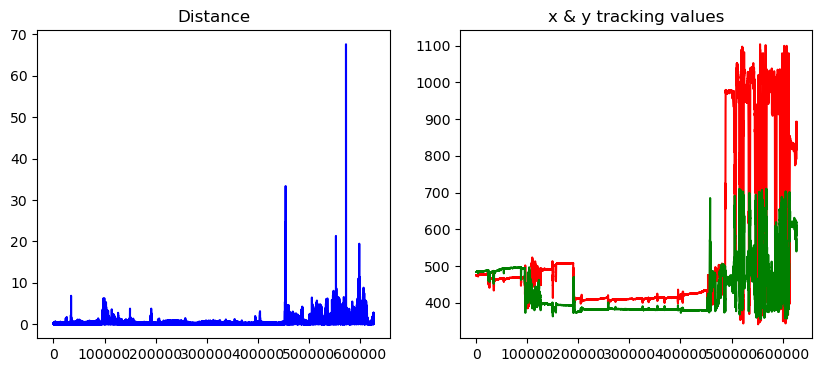

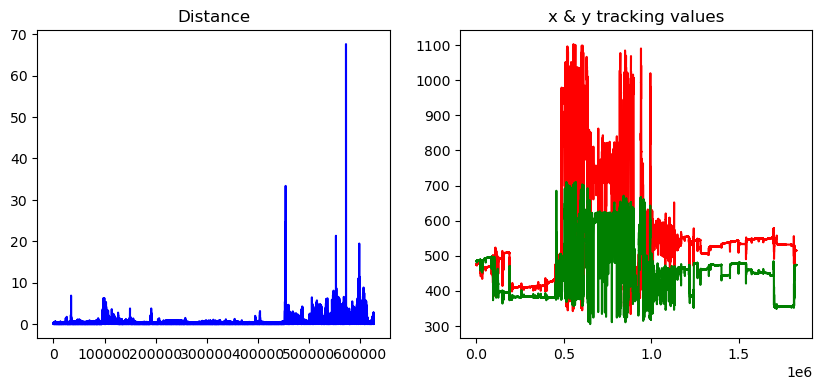

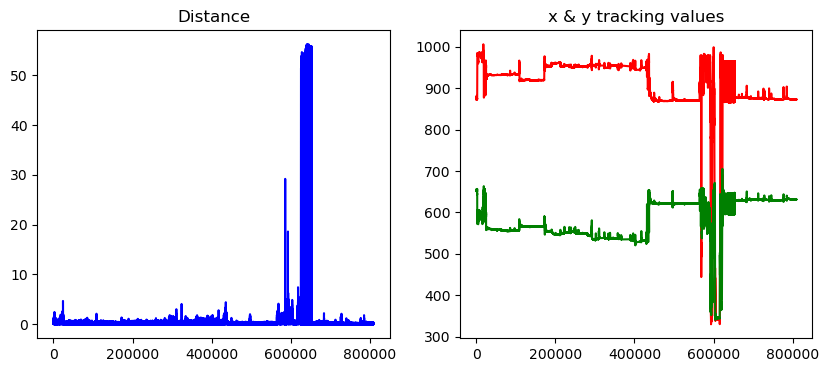

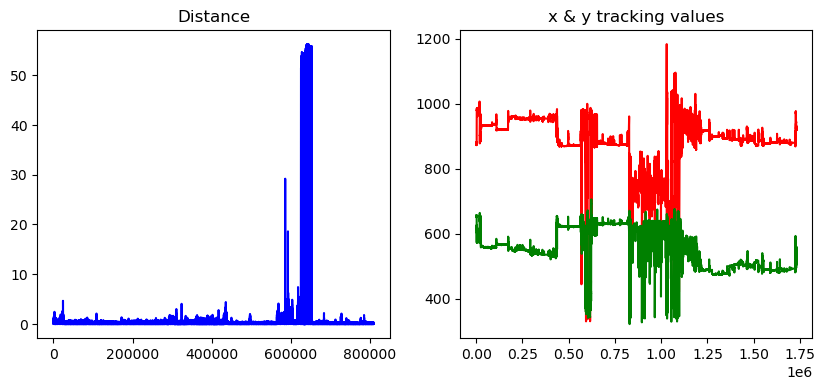

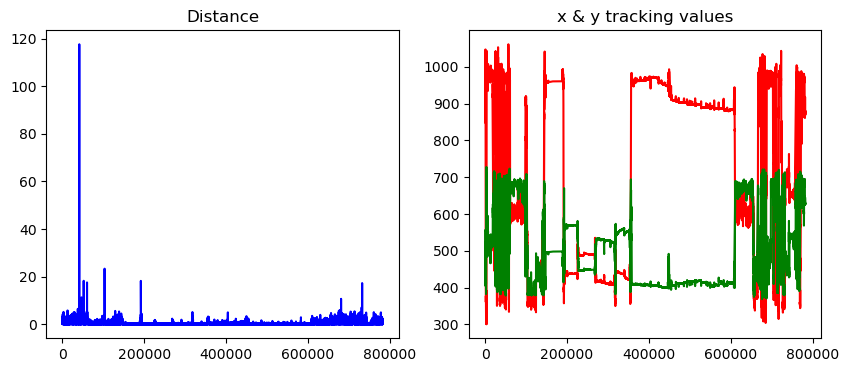

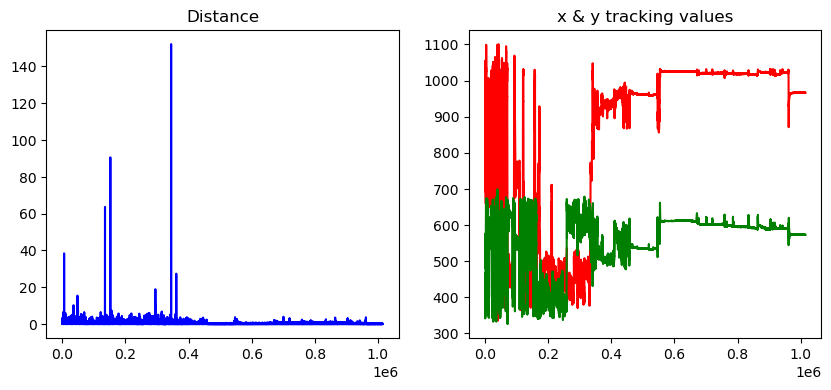

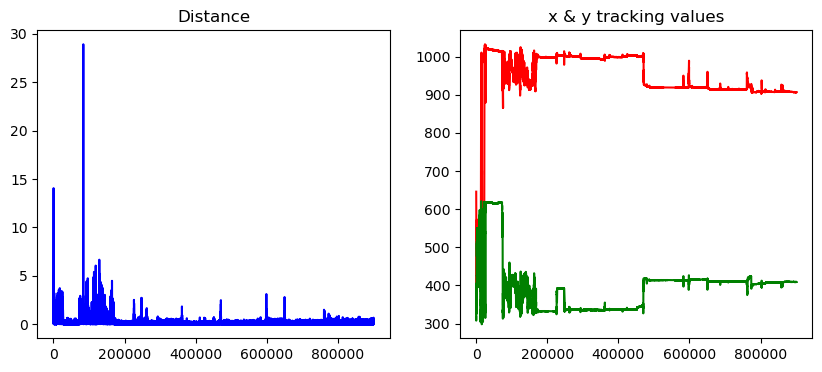

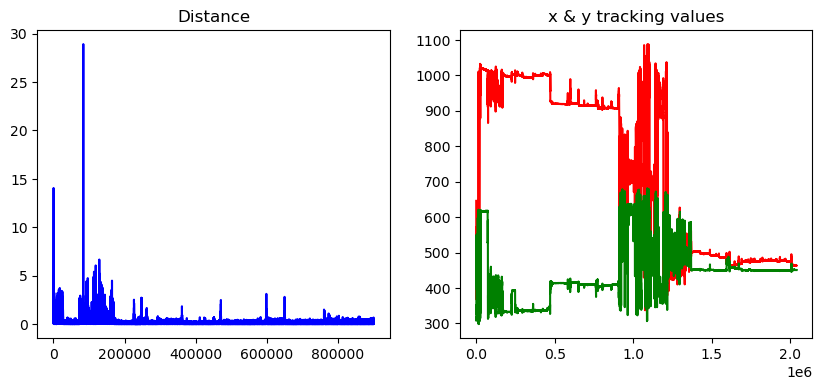

In [68]:
path_ = path+animal
for recording in os.listdir(path_):
    if not 'Store' in recording: # ignore ds store thing
        print(recording)
        current_path = os.path.join(path_,recording) + '\\'
        output_path = os.path.join(path_,recording,'post_process_ppseq') + '\\' 
        
        # presleep        
        video_path = os.path.join(current_path, r"video/videos//")
        Tracking_sleep_data = os.path.join(current_path, r"video/tracking//")
        align_path = os.path.join(current_path, r"behav_sync/1_pre_sleep//") + "Presleep_Ephys_Camera_sync.csv"
        
        # try:
        Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,output_path +'Probe'+Probe+'_velocity_mice_1_presleep.csv',Probe)
        # except:
        #     print('no presleep?')
    
        # post sleep
        video_path = os.path.join(current_path, r"video/videos//")
        Tracking_sleep_data = os.path.join(current_path, r"video/tracking//")
        align_path = os.path.join(current_path, r"behav_sync/3_post_sleep//") + "Postsleep_Ephys_Camera_sync.csv"

        # try:
        Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,output_path + 'Probe'+Probe+'_velocity_mice_3_post_sleep.csv',Probe)       
        # except:
        #     print('no postsleep?')
            

        
        
